# *Google신경망을 이용한 이미지 TEST

`google 신경망 중 Inception_v3을 이용한 결과 Loss rate 감소와 이전 과 다른 변수들의 변화.`

- 이미지 개수 증가 30->60개
- 증가시킨 이미지(30개)는 가능한 객체만 보여질 수 있게편집한 이미지.
  :위의 이미지로 학습한 결과 [학습결과]

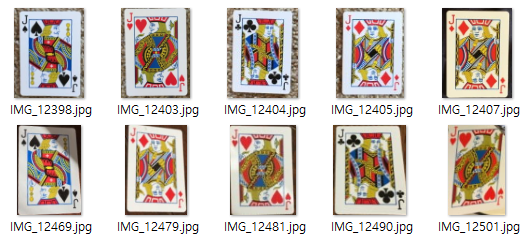
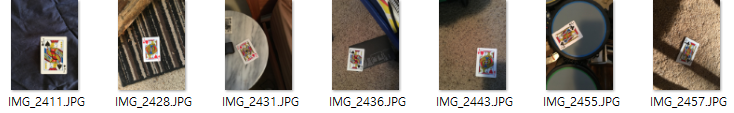

[학습결과]
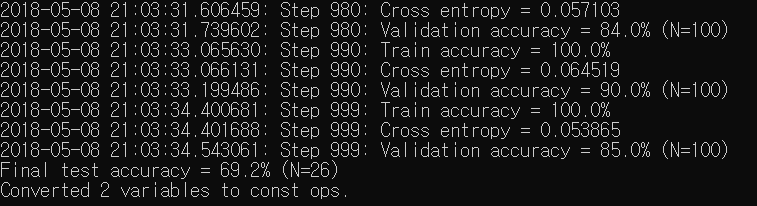


 ***-`이미지에 배경등 결과에 영향이 미치는 변수가 많은 이미지는 낮은확률(0.51045)로 찾음.[사진a],[결과a]`***

[사진a]
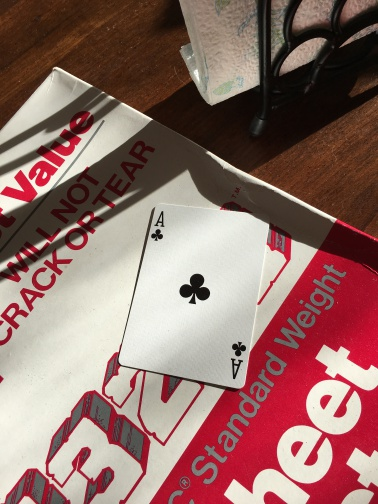
[결과a]
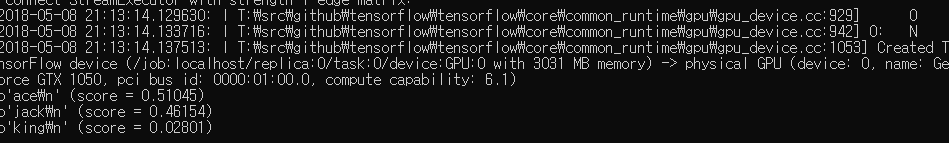

***- `test사진도 가능한 객체만 보여질 수 있게 편집한 이미지를 사용.[사진b]`***

***- `결과 : 99.871% 확률로 ace를 구분함. [결과b]`***


 ***`2~9까지의 사진들을 테스트한 결과 2번 사진제외하고 전부 찾아냄.`

[사진b]
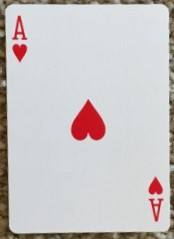
[결과b]
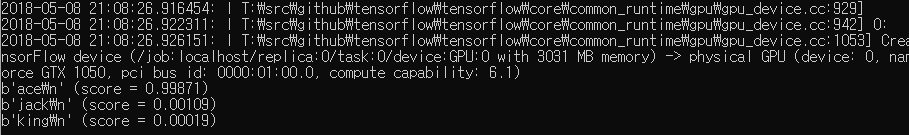

# *논문 Convolutional Neural Networks for Sentence Classification 구현

혼자 구현에는 한계를 느껴, 오픈소스를 찾아봄.(출처:https://ratsgo.github.io/natural%20language%20processing/2017/03/19/CNN/)

cnn_sentence_classification.py

In [ ]:
# 출처 : https://gist.github.com/ratsgo/7ff405f582437dbf96216dd940917427

import os
import time
import datetime
from tensorflow import flags
import tensorflow as tf
import numpy as np
import cnn_tool as tool

class TextCNN(object):
    """
    A CNN for text classification.
    Uses an embedding layer, followed by a convolutional, max-pooling and softmax layer.

    <Parameters>
        - sequence_length: 최대 문장 길이
        - num_classes: 클래스 개수
        - vocab_size: 등장 단어 수
        - embedding_size: 각 단어에 해당되는 임베디드 벡터의 차원
        - filter_sizes: convolutional filter들의 사이즈 (= 각 filter가 몇 개의 단어를 볼 것인가?) (예: "3, 4, 5")
        - num_filters: 각 filter size 별 filter 수
        - l2_reg_lambda: 각 weights, biases에 대한 l2 regularization 정도
    """

    def __init__(
            self, sequence_length, num_classes, vocab_size,
            embedding_size, filter_sizes, num_filters, l2_reg_lambda=0.0):
        # Placeholders for input, output and dropout
        self.input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
        self.input_y = tf.placeholder(tf.float32, [None, num_classes], name="input_y")
        self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")

        # Keeping track of l2 regularization loss (optional)
        l2_loss = tf.constant(0.0)

        # Embedding layer
        """
        <Variable>
            - W: 각 단어의 임베디드 벡터의 성분을 랜덤하게 할당
        """
        with tf.device('/gpu:0'), tf.name_scope("embedding"):
        #with tf.device('/cpu:0'), tf.name_scope("embedding"):
            W = tf.Variable(
                tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0),
                name="W")
            self.embedded_chars = tf.nn.embedding_lookup(W, self.input_x)
            self.embedded_chars_expanded = tf.expand_dims(self.embedded_chars, -1)

        # Create a convolution + maxpool layer for each filter size
        pooled_outputs = []
        for i, filter_size in enumerate(filter_sizes):
            with tf.name_scope("conv-maxpool-%s" % filter_size):
                # Convolution Layer
                filter_shape = [filter_size, embedding_size, 1, num_filters]
                W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
                b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
                conv = tf.nn.conv2d(
                    self.embedded_chars_expanded,
                    W,
                    strides=[1, 1, 1, 1],
                    padding="VALID",
                    name="conv")
                # Apply nonlinearity
                h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
                # Maxpooling over the outputs
                pooled = tf.nn.max_pool(
                    h,
                    ksize=[1, sequence_length - filter_size + 1, 1, 1],
                    strides=[1, 1, 1, 1],
                    padding='VALID',
                    name="pool")
                pooled_outputs.append(pooled)

        # Combine all the pooled features
        num_filters_total = num_filters * len(filter_sizes)
        self.h_pool = tf.concat(3, pooled_outputs)
        self.h_pool_flat = tf.reshape(self.h_pool, [-1, num_filters_total])

        # Add dropout
        with tf.name_scope("dropout"):
            self.h_drop = tf.nn.dropout(self.h_pool_flat, self.dropout_keep_prob)

        # Final (unnormalized) scores and predictions
        with tf.name_scope("output"):
            W = tf.get_variable(
                "W",
                shape=[num_filters_total, num_classes],
                initializer=tf.contrib.layers.xavier_initializer())
            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            self.scores = tf.nn.xw_plus_b(self.h_drop, W, b, name="scores")
            self.predictions = tf.argmax(self.scores, 1, name="predictions")

        # Calculate Mean cross-entropy loss
        with tf.name_scope("loss"):
            losses = tf.nn.softmax_cross_entropy_with_logits(self.scores, self.input_y)
            self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss

        # Accuracy
        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy")

# data loading
data_path = 'C:/Users/ratsgo/GoogleDrive/내폴더/textmining/data/watcha_movie_review_spacecorrected.csv'
contents, points = tool.loading_rdata(data_path, eng=True, num=True, punc=False)
contents = tool.cut(contents,cut=2)

# tranform document to vector
max_document_length = 200
x, vocabulary, vocab_size = tool.make_input(contents,max_document_length)
print('사전단어수 : %s' % (vocab_size))
y = tool.make_output(points,threshold=2.5)

# divide dataset into train/test set
x_train, x_test, y_train, y_test = tool.divide(x,y,train_prop=0.8)


# Model Hyperparameters
flags.DEFINE_integer("embedding_dim", 128, "Dimensionality of embedded vector (default: 128)")
flags.DEFINE_string("filter_sizes", "3,4,5", "Comma-separated filter sizes (default: '3,4,5')")
flags.DEFINE_integer("num_filters", 128, "Number of filters per filter size (default: 128)")
flags.DEFINE_float("dropout_keep_prob", 0.5, "Dropout keep probability (default: 0.5)")
flags.DEFINE_float("l2_reg_lambda", 0.1, "L2 regularization lambda (default: 0.0)")

# Training parameters
flags.DEFINE_integer("batch_size", 64, "Batch Size (default: 64)")
flags.DEFINE_integer("num_epochs", 10, "Number of training epochs (default: 200)")
flags.DEFINE_integer("evaluate_every", 100, "Evaluate model on dev set after this many steps (default: 100)")
flags.DEFINE_integer("checkpoint_every", 100, "Save model after this many steps (default: 100)")
flags.DEFINE_integer("num_checkpoints", 5, "Number of checkpoints to store (default: 5)")

# Misc Parameters
flags.DEFINE_boolean("allow_soft_placement", True, "Allow device soft device placement")
flags.DEFINE_boolean("log_device_placement", False, "Log placement of ops on devices")

FLAGS = tf.flags.FLAGS
FLAGS._parse_flags()
print("\nParameters:")
for attr, value in sorted(FLAGS.__flags.items()):
    print("{}={}".format(attr.upper(), value))
print("")

# 3. train the model and test
with tf.Graph().as_default():
    sess = tf.Session()
    with sess.as_default():
        cnn = TextCNN(sequence_length=x_train.shape[1],
                      num_classes=y_train.shape[1],
                      vocab_size=vocab_size,
                      embedding_size=FLAGS.embedding_dim,
                      filter_sizes=list(map(int, FLAGS.filter_sizes.split(","))),
                      num_filters=FLAGS.num_filters,
                      l2_reg_lambda=FLAGS.l2_reg_lambda)

        # Define Training procedure
        global_step = tf.Variable(0, name="global_step", trainable=False)
        optimizer = tf.train.AdamOptimizer(1e-3)
        grads_and_vars = optimizer.compute_gradients(cnn.loss)
        train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

        # Keep track of gradient values and sparsity (optional)
        grad_summaries = []
        for g, v in grads_and_vars:
            if g is not None:
                grad_hist_summary = tf.summary.histogram("{}".format(v.name), g)
                sparsity_summary = tf.summary.scalar("{}".format(v.name), tf.nn.zero_fraction(g))
                grad_summaries.append(grad_hist_summary)
                grad_summaries.append(sparsity_summary)
        grad_summaries_merged = tf.summary.merge(grad_summaries)

        # Output directory for models and summaries
        timestamp = str(int(time.time()))
        out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
        print("Writing to {}\n".format(out_dir))

        # Summaries for loss and accuracy
        loss_summary = tf.summary.scalar("loss", cnn.loss)
        acc_summary = tf.summary.scalar("accuracy", cnn.accuracy)

        # Train Summaries
        train_summary_op = tf.summary.merge([loss_summary, acc_summary, grad_summaries_merged])
        train_summary_dir = os.path.join(out_dir, "summaries", "train")
        train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

        # Dev summaries
        dev_summary_op = tf.summary.merge([loss_summary, acc_summary])
        dev_summary_dir = os.path.join(out_dir, "summaries", "dev")
        dev_summary_writer = tf.summary.FileWriter(dev_summary_dir, sess.graph)

        # Checkpoint directory. Tensorflow assumes this directory already exists so we need to create it
        checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
        checkpoint_prefix = os.path.join(checkpoint_dir, "model")
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        saver = tf.train.Saver(tf.global_variables(), max_to_keep=FLAGS.num_checkpoints)

        # Initialize all variables
        sess.run(tf.global_variables_initializer())

        def train_step(x_batch, y_batch):
            """
            A single training step
            """
            feed_dict = {
                cnn.input_x: x_batch,
                cnn.input_y: y_batch,
                cnn.dropout_keep_prob: FLAGS.dropout_keep_prob
            }
            _, step, summaries, loss, accuracy = sess.run(
                [train_op, global_step, train_summary_op, cnn.loss, cnn.accuracy],
                feed_dict)
            time_str = datetime.datetime.now().isoformat()
            print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            train_summary_writer.add_summary(summaries, step)


        def dev_step(x_batch, y_batch, writer=None):
            """
            Evaluates model on a dev set
            """
            feed_dict = {
                cnn.input_x: x_batch,
                cnn.input_y: y_batch,
                cnn.dropout_keep_prob: 1.0
            }
            step, summaries, loss, accuracy = sess.run(
                [global_step, dev_summary_op, cnn.loss, cnn.accuracy],
                feed_dict)
            time_str = datetime.datetime.now().isoformat()
            print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            if writer:
                writer.add_summary(summaries, step)


        def batch_iter(data, batch_size, num_epochs, shuffle=True):
            """
            Generates a batch iterator for a dataset.
            """
            data = np.array(data)
            data_size = len(data)
            num_batches_per_epoch = int((len(data) - 1) / batch_size) + 1
            for epoch in range(num_epochs):
                # Shuffle the data at each epoch
                if shuffle:
                    shuffle_indices = np.random.permutation(np.arange(data_size))
                    shuffled_data = data[shuffle_indices]
                else:
                    shuffled_data = data
                for batch_num in range(num_batches_per_epoch):
                    start_index = batch_num * batch_size
                    end_index = min((batch_num + 1) * batch_size, data_size)
                    yield shuffled_data[start_index:end_index]


        # Generate batches
        batches = batch_iter(
            list(zip(x_train, y_train)), FLAGS.batch_size, FLAGS.num_epochs)

        testpoint = 0
        # Training loop. For each batch...
        for batch in batches:
            x_batch, y_batch = zip(*batch)
            train_step(x_batch, y_batch)
            current_step = tf.train.global_step(sess, global_step)
            if current_step % FLAGS.evaluate_every == 0:
                if testpoint + 100 < len(x_test):
                    testpoint += 100
                else:
                    testpoint = 0
                print("\nEvaluation:")
                dev_step(x_test[testpoint:testpoint+100], y_test[testpoint:testpoint+100], writer=dev_summary_writer)
                print("")
            if current_step % FLAGS.checkpoint_every == 0:
                path = saver.save(sess, checkpoint_prefix, global_step=current_step)
                print("Saved model checkpoint to {}\n".format(path))

    cnn_tool.py

In [ ]:
# 출처 : https://gist.github.com/ratsgo/d5c43d40be348987c69466c81edb3904

import numpy as np
import pandas as pd
import re
import tensorflow as tf
import random


####################################################
# cut words function                               #
####################################################
def cut(contents, cut=2):
    results = []
    for content in contents:
        words = content.split()
        result = []
        for word in words:
            result.append(word[:cut])
        results.append(' '.join([token for token in result]))
    return results

####################################################
# divide train/test set function                   #
####################################################
def divide(x, y, train_prop):
    random.seed(1234)
    x = np.array(x)
    y = np.array(y)
    tmp = np.random.permutation(np.arange(len(x)))
    x_tr = x[tmp][:round(train_prop * len(x))]
    y_tr = y[tmp][:round(train_prop * len(x))]
    x_te = x[tmp][-(len(x)-round(train_prop * len(x))):]
    y_te = y[tmp][-(len(x)-round(train_prop * len(x))):]
    return x_tr, x_te, y_tr, y_te


####################################################
# making input function                            #
####################################################
def make_input(documents, max_document_length):
    # tensorflow.contrib.learn.preprocessing 내에 VocabularyProcessor라는 클래스를 이용
    # 모든 문서에 등장하는 단어들에 인덱스를 할당
    # 길이가 다른 문서를 max_document_length로 맞춰주는 역할
    vocab_processor = tf.contrib.learn.preprocessing.VocabularyProcessor(max_document_length)  # 객체 선언
    x = np.array(list(vocab_processor.fit_transform(documents)))
    ### 텐서플로우 vocabulary processor
    # Extract word:id mapping from the object.
    # word to ix 와 유사
    vocab_dict = vocab_processor.vocabulary_._mapping
    # Sort the vocabulary dictionary on the basis of values(id).
    sorted_vocab = sorted(vocab_dict.items(), key=lambda x: x[1])
    # Treat the id's as index into list and create a list of words in the ascending order of id's
    # word with id i goes at index i of the list.
    vocabulary = list(list(zip(*sorted_vocab))[0])
    return x, vocabulary, len(vocab_processor.vocabulary_)

####################################################
# make output function                             #
####################################################
def make_output(points, threshold):
    results = np.zeros((len(points),2))
    for idx, point in enumerate(points):
        if point > threshold:
            results[idx,0] = 1
        else:
            results[idx,1] = 1
    return results

####################################################
# check maxlength function                         #
####################################################
def check_maxlength(contents):
    max_document_length = 0
    for document in contents:
        document_length = len(document.split())
        if document_length > max_document_length:
            max_document_length = document_length
    return max_document_length

####################################################
# loading function                                 #
####################################################
def loading_rdata(data_path, eng=True, num=True, punc=False):
    # R에서 title과 contents만 csv로 저장한걸 불러와서 제목과 컨텐츠로 분리
    # write.csv(corpus, data_path, fileEncoding='utf-8', row.names=F)
    corpus = pd.read_table(data_path, sep=",", encoding="utf-8")
    corpus = np.array(corpus)
    contents = []
    points = []
    for idx,doc in enumerate(corpus):
        if isNumber(doc[0]) is False:
            content = normalize(doc[0], english=eng, number=num, punctuation=punc)
            contents.append(content)
            points.append(doc[1])
        if idx % 100000 is 0:
            print('%d docs / %d save' % (idx, len(contents)))
    return contents, points

def isNumber(s):
  try:
    float(s)
    return True
  except ValueError:
    return False

이 오픈소스와 네이버에서 제공하는 오픈 데이터를 이용해 학습시킬 계획.

## 문제점 발견

<br/>1. 위의 오픈 코드는 낮은버전의 tensorflow 버전에서 작성(1.4.0)되어 현재 버전(1.8.0)에서 작동 불가능 <br/>
    (현재 버전에서 작동하는 오픈소스를 아직 발견 하지 못함)

<br/>2. 때문에 원본코드를 분석해야하는 시간필요.

# *Crawling

   PhantomJS와 python을 이용한 웹크롤링, 저장하기위한 모듈 등 이 많음.

참고 할 사이트 : https://beomi.github.io/2017/01/20/HowToMakeWebCrawler-With-Login/


# *충북여행지 추천시스템

- 크롤링 오픈 소스를 찾던 중 트위터의 정보(사용자 이름 + 사용자 id + 트윗 URL + 트윗 text + 트윗 html + 타임스탬프 + 응답 수 + 리 트윗 수)를 <br/>크롤링해주는 오픈소스를 발견함.

- 충북에 있는 도시명, 좋아요 개수, 리 트윗 수 등을 통해 어느도시의 어떤 관광지를 좋아하는지 정보를 얻을 수 있을 것으로 보임.

- 다음주 ppt 자료에 넣을 수 있으면, 좋은 참고자료가 될 것으로 보임.